In [17]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [1]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_full/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [2]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473332e+08,5.094727e+06,8.082051e+02,5.028689e-01,4.028818e-01,9.854712e-02,3.752564e-01,5.918652e-02,4.195026e-01,1.184329e-01,...,1.145499e-02,1.968431e-02,7.960149e-02,1.344227e-01,9.530649e-03,1.751597e-02,8.878922e-02,7.431632e-02,3.897225e-02,5.331061e-02
std,9.952986e+07,7.972087e+06,2.292125e+03,4.710872e-01,4.523492e-01,2.907154e-01,4.479614e-01,2.284392e-01,2.256374e-01,7.151420e-02,...,5.399123e-02,8.007008e-02,1.179461e-01,1.749526e-01,5.258238e-02,8.241773e-02,1.050750e-01,9.861962e-02,9.868933e-02,1.123964e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.926878e+07,4.672090e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.368196e+08,1.634092e+06,1.990000e+02,6.774194e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433434e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,5.416341e-02,3.541864e-02,0.000000e+00,0.000000e+00
75%,2.260676e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.390244e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.860562e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,1.365586e-01,1.118571e-01,0.000000e+00,4.670041e-02
max,3.617734e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [3]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [4]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.7022064651322837


## Model Creation

In [5]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


### Full Model

In [6]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43
random_state=43
random_state=43
random_state=43random_state=43

metrics={'accuracy': 0.8755693871174623, 'precision': 0.8987540789083358, 'recall': 0.9489014516811, 'f1': 0.9231472382824105}

Confusion matrix:
[[ 31195  20478]
 [  9789 181782]]

Classification report:
              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51673
        True       0.90      0.95      0.92    191571

    accuracy                           0.88    243244
   macro avg       0.83      0.78      0.80    243244
weighted avg       0.87      0.88      0.87    243244

metrics={'accuracy': 0.8730369505517094, 'precision': 0.8960824864389965, 'recall': 0.9486409096134352, 'f1': 0.9216129711838896}

Confusion matrix:
[[ 30812  21054]
 [  9829 181549]]

Classification report:
              precision    recall  f1-score   support

       False       0.76      0.59      0.67     51866
        True       0.90      0.95      0.92    191378

    accuracy    

### Control + Intra-project Model

In [7]:
from python_proj.utils.util import get_matching

ci_re = r".*(Control|Intra).*"
contr_with_intra = list(get_matching(independent_fields, ci_re))
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
random_state=45
random_state=45
random_state=45
random_state=45
random_state=45
metrics={'accuracy': 0.8562842248935225, 'precision': 0.8913835770528684, 'recall': 0.9309145777968058, 'f1': 0.9107203056523205}

Confusion matrix:
[[ 29987  21726]
 [ 13232 178299]]

Classification report:
              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51713
        True       0.89      0.93  

### Collaboration and Ecosystem Model

In [8]:
from python_proj.utils.util import get_non_matching

non_control_intra_fields = list(get_non_matching(independent_fields, ci_re))
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentC

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]

random_state=49
metrics={'accuracy': 0.8736870233714978, 'precision': 0.8975584415584416, 'recall': 0.9476645180162768, 'f1': 0.9219311774734922}

Confusion matrix:
[[ 31101  20706]
 [ 10019 181419]]

Classification report:
              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51807
        True       0.90      0.95      0.92    191438

    accuracy                           0.87    243245
   macro avg       0.83      0.77      0.80    243245
weighted avg       0.87      0.87      0.87    243245



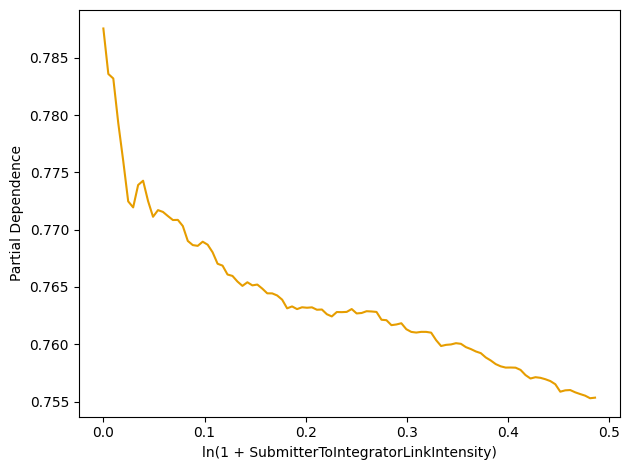

In [10]:
from python_proj.modelling.notebooks.random_forest.rf_functions import create_model
from python_proj.modelling.notebooks.random_forest.pd_functions import (
    create_partial_dependence_plots,
)

full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

output_path = f"{figure_base_path}/partial-dependence/"
create_partial_dependence_plots(full_rf_model, test_predictors, output_path)

### Mean decrease in Impurity

/tmp/ipykernel_35384/72007592.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


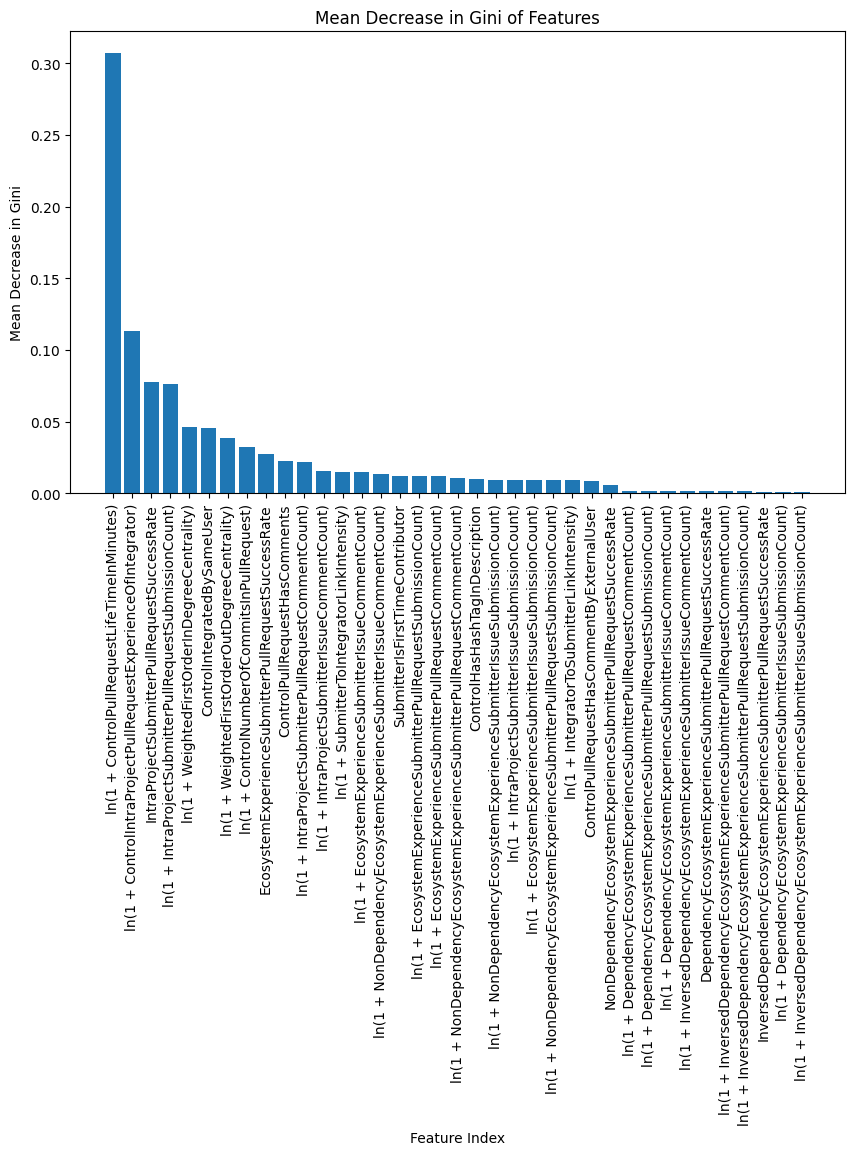

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.3068
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.1135
IntraProjectSubmitterPullRequestSuccessRate: 0.0779
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.0764
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0466
ControlIntegratedBySameUser: 0.0459
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0384
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0325
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0275
ControlPullRequestHasComments: 0.0228
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.0216
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.0157
ln(1 + SubmitterToIntegratorLinkIntensity): 0.0152
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0145
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.0133
SubmitterIsFirstTimeContributor: 0.0121
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0119
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCou

In [11]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f"{field}: {importance:.04f}")

### Variable Group Ablation Studies

Performs an ablation and a reverse ablation study using different feature groups:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [12]:
from python_proj.utils.util import get_matching

# Generates variable groups

var_group_regex_patterns = [
    ("control", r".*Control.*"),
    ("intra", r"^(?!.*Control).*(?=Intra).*"),
    ("eco", r"^(?!.*Dependency).*(?=Ecosystem).*"),
    ("deco", r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    ("ideco", r".*(?=Inverse).*"),
    ("ndeco", r".*(?=NonDependency).*"),
    ("coll", r".*(Weighted|LinkIntensity).*"),
]

var_groups = [
    (name, list(get_matching(independent_fields, pattern)))
    for name, pattern in var_group_regex_patterns
]

#### Regular Ablation
Creates models with subsets of the features to test their impact on the predictions in isolation.

In [13]:
abl_results = dict()

for cluster_name, cluster in var_groups:
    used_fields = list([field for field in independent_fields if field not in cluster])
    print(
        f'Ablation with "{cluster_name}", excluding: {list(cluster)}, including: {used_fields}.'
    )

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )


# Prints summarized results again for clarity.
for cluster_name, (f1_scores, f1_mean, f1_std) in abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Ablation with "control", excluding: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'], including: ['IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissi

#### Reverse ablation

Performs a reverse ablation study, such that models are created using ONLY the subset of variables.

In [14]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups:
    print(f'Reverse ablation with "{cluster_name}", including: {list(cluster)}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

# Prints summarized results again for clarity.
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse ablation with "control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].
random_state=64
random_state=64
random_state=64
random_state=64
random_state=64
metrics={'accuracy': 0.7992065612859462, 'precision': 0.849518016139714, 'recall': 0.9050523422025013, 'f1': 0.8764063140527656}

Confusion matrix:
[[ 21233  30675]
 [ 18167 173170]]

Classification report:
metrics={'accuracy': 0.8007391754781207, 'precision': 0.8505548886547931, 'recall': 0.9062026915567806, 'f1': 0.877497428328072}

Confusion matrix:
[[ 21181  30501]
 [ 17968 173594]]

Classification report:
              precision    recall  f1-score   support

       False       0.54      0.41      0.47     51908
        True       0.85      0.91      0.88    19

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [15]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.7873338809311795.
{
    "accuracy": 0.6640835371744538,
    "precision": 0.7865858754701212,
    "recall": 0.7865940931267564,
    "f1": 0.786589984276976
}


In [16]:
import datetime

print(datetime.datetime.now())

2024-01-30 15:02:15.868901
